# ann-project

5조
한수호, 강구현, 김민규, 홍준기

# Setup

In [1]:
from models.simple_cnn import CNNModel
from models.residual import ResModel
from models.resnet50 import ResNetModel
from models.lenet import LeNetModel
from keras import callbacks, optimizers, layers
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import seaborn as sns
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

2024-05-27 15:10:47.276159: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 15:10:47.276198: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 15:10:47.276234: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 15:10:47.283166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 15:10:48.008380: W tensorflow/compiler/

In [2]:
from datetime import datetime
result_path = './results'
_time = datetime.strftime(datetime.today(), '%Y-%m-%d_%H-%M-%S')

dataset

In [3]:
train_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-train.csv'
test_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-test.csv'

chunk_size = 10000
train_data_iter = pd.read_csv(train_file_path, chunksize=chunk_size)
train_data = pd.concat([chunk for chunk in tqdm(train_data_iter, desc='Loading training data')])
test_data_iter = pd.read_csv(test_file_path, chunksize=chunk_size)
test_data = pd.concat([chunk for chunk in tqdm(test_data_iter, desc='Loading test data')])

# Data dimensions and sizes
num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

# Prepare data
x_train = train_data.iloc[:, 1:].to_numpy().reshape((num_train_samples, 28, 28, 1))
x_test = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_train = tf.keras.utils.to_categorical(train_data.iloc[:, 0], 62)  # 62 classes for EMNIST ByClass
y_test = tf.keras.utils.to_categorical(test_data.iloc[:, 0], 62)

# Integer labels for sparse categorical crossentropy
y_train_int = train_data.iloc[:, 0].to_numpy()
y_test_int = test_data.iloc[:, 0].to_numpy()

# Split the training data into training and validation sets
_, _, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_train, x_valid, y_train_int, y_valid_int = train_test_split(x_train, y_train_int, test_size=0.1, random_state=42)

# Prepare data for ResNet
x_train_resized = tf.image.resize(x_train, [32, 32])
x_valid_resized = tf.image.resize(x_valid, [32, 32])
x_test_resized = tf.image.resize(x_test, [32, 32])

Loading training data: 70it [00:14,  4.72it/s]
Loading test data: 12it [00:02,  4.72it/s]
2024-05-27 15:11:15.175286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 15:11:15.204150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 15:11:15.204447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node ze

checkpoints

In [4]:
def create_callbacks(model_name):
    current_time = int(time.time())
    checkpoint_path = f"./checkpoints/checkpoints_{model_name}/weights.{current_time}.hdf5"

    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)
    checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

    return [reduce_lr, checkpoint]


callbacks_lenet = create_callbacks('lenet')
callbacks_resnet = create_callbacks('resnet')
callbacks_ours_1 = create_callbacks('ours_1')
callbacks_ours_2 = create_callbacks('ours_2')
callbacks_final = create_callbacks('final')

test results

In [5]:
def save_results(results_df):
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    results_df.to_csv(os.path.join(result_path, f'result_{_time}.csv'), index=False)

saving history

In [6]:
def save_history(histories, filename):
    with open(os.path.join(result_path, filename), 'wb') as f:
        pickle.dump(histories, f)

# 1. baseline과 our 모델 비교

In [ ]:
# Initialize models
lenet_model = LeNetModel()
resnet_model = ResNetModel()
our_model_1 = CNNModel()
our_model_2res = ResModel()

# Compile models
lenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = []
training_time = []

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
start_time = time.time()
history.append(lenet_model.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_lenet]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
start_time = time.time()
history.append(resnet_model.train(x_train_resized, y_train_int, validation_data=(x_valid_resized,
               y_valid_int), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_resnet]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
start_time = time.time()
history.append(our_model_1.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_ours_1]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
start_time = time.time()
history.append(our_model_2res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_ours_2]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
loss_lenet, acc_lenet = lenet_model.evaluate(x_test, y_test_int)
loss_resnet, acc_resnet = resnet_model.evaluate(x_test_resized, y_test_int)
loss_our1, acc_our1 = our_model_1.evaluate(x_test, y_test_int)
loss_our2, acc_our2 = our_model_2res.evaluate(x_test, y_test_int)

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history, f)

In [ ]:
results = {
    "Model": ["LeNet-5", "ResNet-50", "Our Model(CNN)", "Our Model(Residual)"],
    "Loss": [loss_lenet, loss_resnet, loss_our1, loss_our2],
    "Accuracy": [acc_lenet, acc_resnet, acc_our1, acc_our2],
    "Training Time": training_time
}
result_path = './results'
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_{_time}.csv', index=False)

In [ ]:
colors = ["red", "blue", "green", "purple", "gold"]

plt.figure(figsize=(10, 5))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_{_time}.png")
plt.show()
save_history(history, 'history_activation.pkl')

In [ ]:
training_time.append("")
results = {
    "Model": ["LeNet-5", "ResNet-50", "Our Model", "Wavemix-256[6]"],
    "Loss": [loss_lenet, loss_resnet, loss_our1, loss_our2, 0],
    "Accuracy": [acc_lenet, acc_resnet, acc_our1, acc_our2, 0.8842],
    "Training Time": training_time
}
results_df = pd.DataFrame(results)

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(5, 6))
    sns.barplot(x="Model", y=metric, hue="Model", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_{_time}.png')
    plt.show()

# 2. Experiment

## 2.1. Optimizer

In [55]:
optimizers_list = [
    optimizers.SGD(learning_rate=0.001, momentum=0.9),
    optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    optimizers.Adagrad(learning_rate=0.001),
    optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
]

In [56]:
history = []
results = {'Optimizer': [], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [57]:
def _train_opt(x_train, y_train, validation_data, optimizer, activation_ftn='ReLU'):
    print(f"Start with {type(optimizer).__name__}")
    final_model = ResModel(num_classes=62, initial_filters=32,
                           dropout_rate=0.3, final_dropout_rate=0.6, activation=activation_ftn, num_residual_units=3)
    optimizer.build(final_model.model.trainable_variables)

    final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = final_model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                             batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = final_model.evaluate(x_test, y_test_int)
    results['Optimizer'].append(type(optimizer).__name__)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

    print(f"End with {type(optimizer).__name__}")

In [58]:
EPOCHS = 10
BATCH_SIZE = 500

In [59]:
for optimizer in optimizers_list:
    _train_opt(x_train, y_train_int, (x_valid, y_valid_int), optimizer, activation_ftn='ReLU')

Start with SGD
Epoch 1/10


2024-05-27 19:55:15.604934: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_26/dropout_131/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 1.5753 - accuracy: 0.5940
Epoch 1: val_loss did not improve from 0.31543
1257/1257 [==============================] - 30s 20ms/step - loss: 1.5746 - accuracy: 0.5941 - val_loss: 0.6648 - val_accuracy: 0.7876 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.8054 - accuracy: 0.7526
Epoch 2: val_loss did not improve from 0.31543
1257/1257 [==============================] - 25s 20ms/step - loss: 0.8054 - accuracy: 0.7526 - val_loss: 0.5209 - val_accuracy: 0.8251 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.7879
Epoch 3: val_loss did not improve from 0.31543
1257/1257 [==============================] - 25s 20ms/step - loss: 0.6600 - accuracy: 0.7879 - val_loss: 0.4733 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.5926 - accuracy: 0.8050
Epoch 4: val_loss did not improve 

2024-05-27 19:59:43.067392: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_27/dropout_136/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 1.5536 - accuracy: 0.5987
Epoch 1: val_loss did not improve from 0.31543
1257/1257 [==============================] - 28s 20ms/step - loss: 1.5529 - accuracy: 0.5988 - val_loss: 0.6372 - val_accuracy: 0.7978 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.7915 - accuracy: 0.7562
Epoch 2: val_loss did not improve from 0.31543
1257/1257 [==============================] - 25s 20ms/step - loss: 0.7914 - accuracy: 0.7563 - val_loss: 0.5147 - val_accuracy: 0.8252 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.6509 - accuracy: 0.7903
Epoch 3: val_loss did not improve from 0.31543
1257/1257 [==============================] - 25s 20ms/step - loss: 0.6508 - accuracy: 0.7903 - val_loss: 0.4670 - val_accuracy: 0.8369 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.5878 - accuracy: 0.8064
Epoch 4: val_loss did not improve 

2024-05-27 20:04:10.986501: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_28/dropout_141/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 2.4386 - accuracy: 0.4224
Epoch 1: val_loss did not improve from 0.31543
1257/1257 [==============================] - 28s 20ms/step - loss: 2.4378 - accuracy: 0.4225 - val_loss: 1.1943 - val_accuracy: 0.6835 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 1.4117 - accuracy: 0.6258
Epoch 2: val_loss did not improve from 0.31543
1257/1257 [==============================] - 25s 20ms/step - loss: 1.4116 - accuracy: 0.6258 - val_loss: 0.8731 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 3/10
1254/1257 [============================>.] - ETA: 0s - loss: 1.1228 - accuracy: 0.6840
Epoch 3: val_loss did not improve from 0.31543
1257/1257 [==============================] - 25s 20ms/step - loss: 1.1227 - accuracy: 0.6841 - val_loss: 0.7247 - val_accuracy: 0.7747 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.9706 - accuracy: 0.7156
Epoch 4: val_loss did not improve 

2024-05-27 20:08:38.129722: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_29/dropout_146/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1254/1257 [============================>.] - ETA: 0s - loss: 0.5544 - accuracy: 0.8154
Epoch 1: val_loss did not improve from 0.31543
1257/1257 [==============================] - 28s 20ms/step - loss: 0.5541 - accuracy: 0.8155 - val_loss: 0.4149 - val_accuracy: 0.8496 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4018 - accuracy: 0.8550
Epoch 2: val_loss did not improve from 0.31543
1257/1257 [==============================] - 25s 20ms/step - loss: 0.4018 - accuracy: 0.8550 - val_loss: 0.4481 - val_accuracy: 0.8411 - lr: 0.0010
Epoch 3/10
1254/1257 [============================>.] - ETA: 0s - loss: 0.3798 - accuracy: 0.8615
Epoch 3: val_loss did not improve from 0.31543
1257/1257 [==============================] - 25s 20ms/step - loss: 0.3798 - accuracy: 0.8615 - val_loss: 0.4095 - val_accuracy: 0.8460 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3682 - accuracy: 0.8658
Epoch 4: val_loss did not improve 

2024-05-27 20:13:04.984676: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_30/dropout_151/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1254/1257 [============================>.] - ETA: 0s - loss: 0.5718 - accuracy: 0.8117
Epoch 1: val_loss did not improve from 0.31543
1257/1257 [==============================] - 30s 20ms/step - loss: 0.5716 - accuracy: 0.8117 - val_loss: 0.4062 - val_accuracy: 0.8527 - lr: 0.0010
Epoch 2/10
1254/1257 [============================>.] - ETA: 0s - loss: 0.4026 - accuracy: 0.8541
Epoch 2: val_loss did not improve from 0.31543
1257/1257 [==============================] - 25s 20ms/step - loss: 0.4026 - accuracy: 0.8541 - val_loss: 0.3688 - val_accuracy: 0.8617 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3800 - accuracy: 0.8606
Epoch 3: val_loss did not improve from 0.31543
1257/1257 [==============================] - 25s 20ms/step - loss: 0.3801 - accuracy: 0.8605 - val_loss: 0.3637 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3669 - accuracy: 0.8645
Epoch 4: val_loss did not improve 

2024-05-27 20:17:36.643820: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_31/dropout_156/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.6967 - accuracy: 0.7834
Epoch 1: val_loss did not improve from 0.31543
1257/1257 [==============================] - 29s 20ms/step - loss: 0.6965 - accuracy: 0.7835 - val_loss: 0.4015 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 2/10
1254/1257 [============================>.] - ETA: 0s - loss: 0.4323 - accuracy: 0.8471
Epoch 2: val_loss did not improve from 0.31543
1257/1257 [==============================] - 25s 20ms/step - loss: 0.4322 - accuracy: 0.8471 - val_loss: 0.3707 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3933 - accuracy: 0.8576
Epoch 3: val_loss did not improve from 0.31543
1257/1257 [==============================] - 24s 19ms/step - loss: 0.3933 - accuracy: 0.8576 - val_loss: 0.3541 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3752 - accuracy: 0.8625
Epoch 4: val_loss did not improve 

2024-05-27 20:22:09.095459: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_32/dropout_161/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.5700 - accuracy: 0.8131
Epoch 1: val_loss did not improve from 0.31543
1257/1257 [==============================] - 37s 25ms/step - loss: 0.5699 - accuracy: 0.8132 - val_loss: 0.3824 - val_accuracy: 0.8592 - lr: 0.0010
Epoch 2/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.4009 - accuracy: 0.8546
Epoch 2: val_loss did not improve from 0.31543
1257/1257 [==============================] - 31s 24ms/step - loss: 0.4009 - accuracy: 0.8547 - val_loss: 0.3866 - val_accuracy: 0.8570 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3773 - accuracy: 0.8613
Epoch 3: val_loss did not improve from 0.31543
1257/1257 [==============================] - 29s 23ms/step - loss: 0.3773 - accuracy: 0.8613 - val_loss: 0.3638 - val_accuracy: 0.8641 - lr: 0.0010
Epoch 4/10
1257/1257 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8646
Epoch 4: val_loss did not improve 

In [60]:
results_df = pd.DataFrame(results)
save_results(results_df)
save_history(history, 'history_optimizer.pkl')

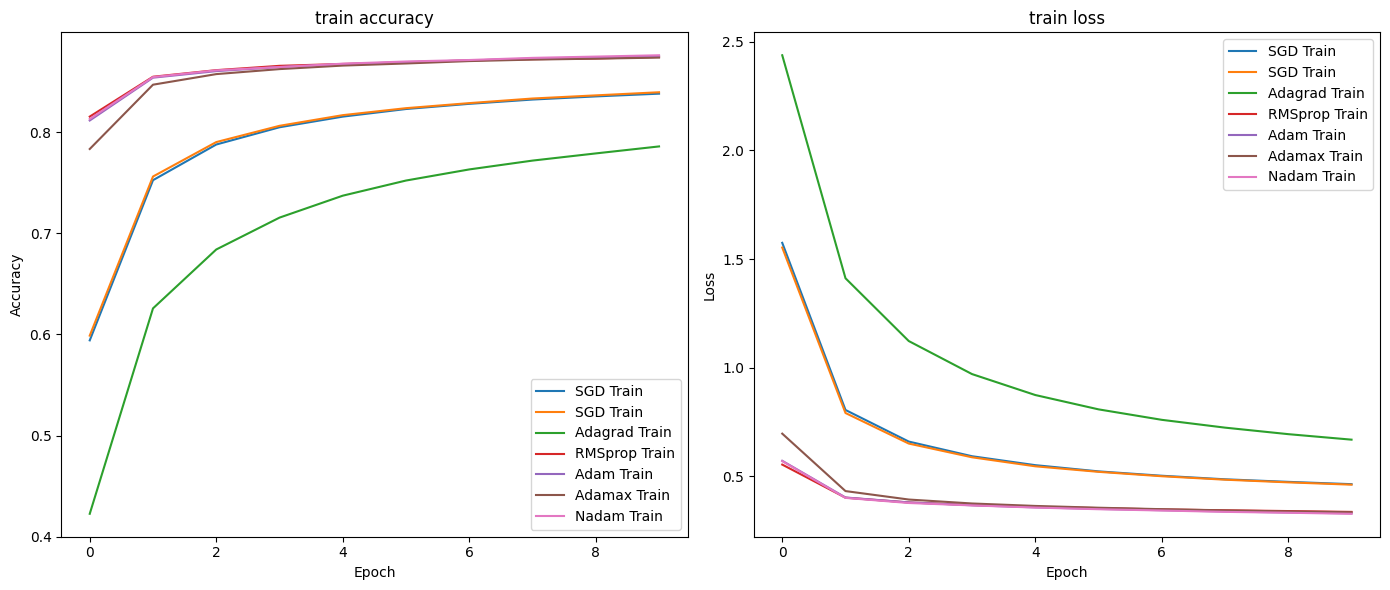

In [61]:
plt.figure(figsize=(14, 6))

for i, h in enumerate(history):
    plt.subplot(1, 2, 1)
    plt.plot(h.history['accuracy'], label=f'{type(optimizers_list[i]).__name__} Train')
    plt.title('train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(h.history['loss'], label=f'{type(optimizers_list[i]).__name__} Train')
    plt.title('train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig(f"{result_path}/result_{_time}.png")
save_history(history, 'history_optimizer.pkl')
plt.show()

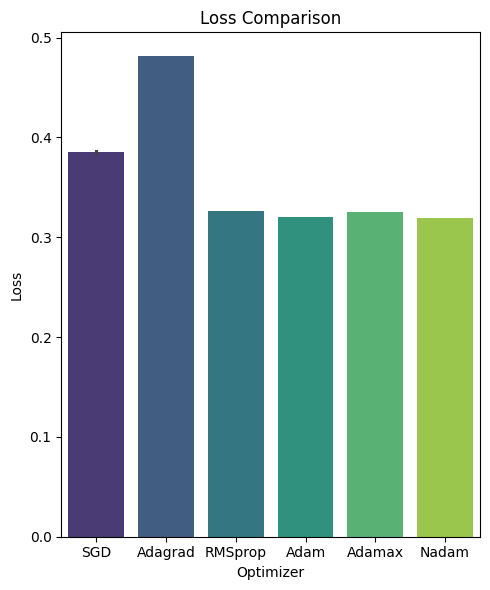

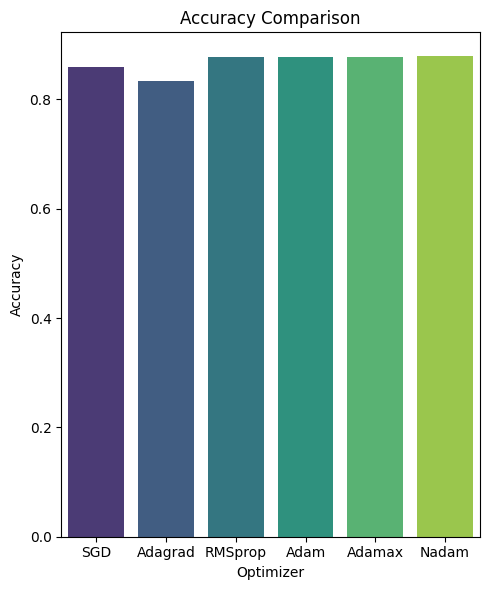

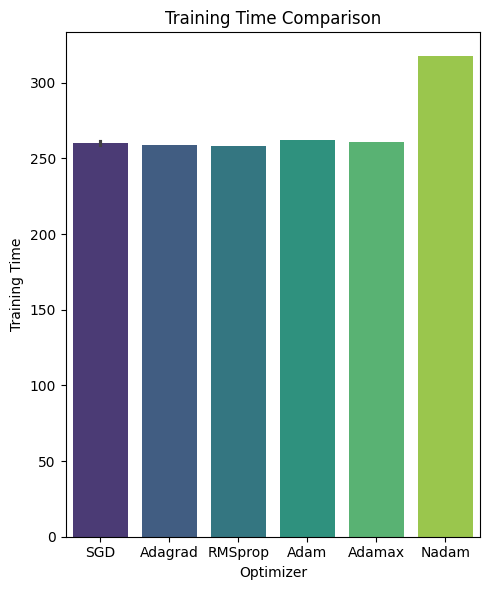

In [62]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(5, 6))
    sns.barplot(x="Optimizer", y=metric, hue="Optimizer", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Optimizer')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_{_time}.png')
    plt.show()

## 2.2. Activation Function

In [35]:
activations = {
    'relu': layers.ReLU(),
    'leaky_relu': layers.LeakyReLU(),
    'elu': layers.ELU(),
    'selu': layers.Activation('selu'),
    'sigmoid': layers.Activation('sigmoid'),
    'tanh': layers.Activation('tanh'),
    'softmax': layers.Activation('softmax'),
    'softplus': layers.Activation('softplus'),
    'softsign': layers.Activation('softsign'),
    'swish': layers.Activation('swish'),
    'gelu': layers.Activation('gelu')
}

In [36]:
history = []
results = {'Activation Function': [], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [37]:
best_optimizer = optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
activation_functions = ['relu', 'leaky_relu', 'elu', 'selu', 'sigmoid', 'tanh',
                        'softmax', 'softplus', 'softsign', 'swish', 'gelu']

In [38]:
def _train_act(x_train, y_train, validation_data, optimizer, activation_ftn):
    print(f"Start with {activation_ftn}")

    activation_layer = activations.get(activation_ftn, layers.ReLU())

    final_model = ResModel(num_classes=62, initial_filters=32, dropout_rate=0.3,
                           final_dropout_rate=0.6, activation=activation_layer, num_residual_units=3)
    final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = final_model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                             batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = final_model.evaluate(x_test, y_test_int)
    results['Activation Function'].append(activation_ftn)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

    print(f"End with {activation_ftn}")

In [39]:
EPOCHS = 10
BATCH_SIZE = 500

In [40]:
for ftn in activation_functions:
    _train_act(x_train, y_train_int, (x_valid, y_valid_int), optimizer=best_optimizer, activation_ftn=ftn)

Start with relu
Epoch 1/10


2024-05-27 17:19:40.141360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/dropout_57/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5727 - accuracy: 0.8120
Epoch 1: val_loss did not improve from 0.31287
1257/1257 [==============================] - 25s 19ms/step - loss: 0.5726 - accuracy: 0.8121 - val_loss: 0.4378 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4017 - accuracy: 0.8543
Epoch 2: val_loss did not improve from 0.31287
1257/1257 [==============================] - 23s 19ms/step - loss: 0.4017 - accuracy: 0.8544 - val_loss: 0.3790 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3794 - accuracy: 0.8608
Epoch 3: val_loss did not improve from 0.31287
1257/1257 [==============================] - 23s 19ms/step - loss: 0.3794 - accuracy: 0.8608 - val_loss: 0.3533 - val_accuracy: 0.8678 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3670 - accuracy: 0.8646
Epoch 4: val_loss did not improve 

2024-05-27 17:23:54.664020: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_12/dropout_62/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5586 - accuracy: 0.8124
Epoch 1: val_loss did not improve from 0.31287
1257/1257 [==============================] - 27s 19ms/step - loss: 0.5585 - accuracy: 0.8125 - val_loss: 0.4086 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4254 - accuracy: 0.8477
Epoch 2: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4253 - accuracy: 0.8478 - val_loss: 0.3791 - val_accuracy: 0.8619 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4017 - accuracy: 0.8546
Epoch 3: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4016 - accuracy: 0.8546 - val_loss: 0.3835 - val_accuracy: 0.8598 - lr: 0.0010
Epoch 4/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.3891 - accuracy: 0.8581
Epoch 4: val_loss did not improve 

2024-05-27 17:28:08.858218: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_13/dropout_67/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5756 - accuracy: 0.8076
Epoch 1: val_loss did not improve from 0.31287
1257/1257 [==============================] - 25s 19ms/step - loss: 0.5754 - accuracy: 0.8077 - val_loss: 0.4092 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4267 - accuracy: 0.8470
Epoch 2: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4267 - accuracy: 0.8470 - val_loss: 0.3854 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4018 - accuracy: 0.8541
Epoch 3: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4018 - accuracy: 0.8541 - val_loss: 0.3754 - val_accuracy: 0.8632 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3865 - accuracy: 0.8587
Epoch 4: val_loss did not improve 

2024-05-27 17:32:25.237021: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_14/dropout_72/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.6915 - accuracy: 0.7797
Epoch 1: val_loss did not improve from 0.31287
1257/1257 [==============================] - 25s 19ms/step - loss: 0.6913 - accuracy: 0.7798 - val_loss: 0.4367 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4634 - accuracy: 0.8367
Epoch 2: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4634 - accuracy: 0.8367 - val_loss: 0.4083 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4294 - accuracy: 0.8464
Epoch 3: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4294 - accuracy: 0.8464 - val_loss: 0.3926 - val_accuracy: 0.8558 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4104 - accuracy: 0.8515
Epoch 4: val_loss did not improve 

2024-05-27 17:36:39.843907: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_15/dropout_77/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.8417 - accuracy: 0.7409
Epoch 1: val_loss did not improve from 0.31287
1257/1257 [==============================] - 26s 20ms/step - loss: 0.8414 - accuracy: 0.7410 - val_loss: 1.3703 - val_accuracy: 0.6511 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4826 - accuracy: 0.8319
Epoch 2: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4825 - accuracy: 0.8319 - val_loss: 0.4578 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4407 - accuracy: 0.8440
Epoch 3: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4407 - accuracy: 0.8440 - val_loss: 0.4144 - val_accuracy: 0.8488 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4190 - accuracy: 0.8500
Epoch 4: val_loss did not improve 

2024-05-27 17:40:55.810834: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_16/dropout_82/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1254/1257 [============================>.] - ETA: 0s - loss: 0.5883 - accuracy: 0.8037
Epoch 1: val_loss did not improve from 0.31287
1257/1257 [==============================] - 25s 19ms/step - loss: 0.5881 - accuracy: 0.8038 - val_loss: 0.4181 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4358 - accuracy: 0.8454
Epoch 2: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4358 - accuracy: 0.8454 - val_loss: 0.3913 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4114 - accuracy: 0.8517
Epoch 3: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4113 - accuracy: 0.8517 - val_loss: 0.3784 - val_accuracy: 0.8624 - lr: 0.0010
Epoch 4/10
1254/1257 [============================>.] - ETA: 0s - loss: 0.3958 - accuracy: 0.8561
Epoch 4: val_loss did not improve 

2024-05-27 17:45:11.191014: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model_17/dropout_90/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 2.2221 - accuracy: 0.5872
Epoch 1: val_loss did not improve from 0.31287
1257/1257 [==============================] - 28s 21ms/step - loss: 2.2215 - accuracy: 0.5872 - val_loss: 1.2679 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 1.4919 - accuracy: 0.6634
Epoch 2: val_loss did not improve from 0.31287
1257/1257 [==============================] - 26s 21ms/step - loss: 1.4917 - accuracy: 0.6634 - val_loss: 0.9313 - val_accuracy: 0.7544 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 1.2837 - accuracy: 0.6835
Epoch 3: val_loss did not improve from 0.31287
1257/1257 [==============================] - 26s 21ms/step - loss: 1.2835 - accuracy: 0.6835 - val_loss: 0.7492 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 1.1463 - accuracy: 0.7020
Epoch 4: val_loss did not improve 

2024-05-27 17:49:51.325840: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_18/dropout_92/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.6643 - accuracy: 0.7841
Epoch 1: val_loss did not improve from 0.31287
1257/1257 [==============================] - 26s 20ms/step - loss: 0.6641 - accuracy: 0.7842 - val_loss: 0.4473 - val_accuracy: 0.8394 - lr: 0.0010
Epoch 2/10
1254/1257 [============================>.] - ETA: 0s - loss: 0.4469 - accuracy: 0.8408
Epoch 2: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4468 - accuracy: 0.8408 - val_loss: 0.3958 - val_accuracy: 0.8556 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4143 - accuracy: 0.8503
Epoch 3: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4143 - accuracy: 0.8503 - val_loss: 0.3813 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3974 - accuracy: 0.8553
Epoch 4: val_loss did not improve 

2024-05-27 17:54:12.546812: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model_19/dropout_100/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5971 - accuracy: 0.8010
Epoch 1: val_loss did not improve from 0.31287
1257/1257 [==============================] - 26s 19ms/step - loss: 0.5970 - accuracy: 0.8011 - val_loss: 0.4183 - val_accuracy: 0.8520 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4426 - accuracy: 0.8433
Epoch 2: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4426 - accuracy: 0.8433 - val_loss: 0.3988 - val_accuracy: 0.8570 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4175 - accuracy: 0.8502
Epoch 3: val_loss did not improve from 0.31287
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4175 - accuracy: 0.8502 - val_loss: 0.3933 - val_accuracy: 0.8591 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4039 - accuracy: 0.8542
Epoch 4: val_loss did not improve 

2024-05-27 17:58:29.166439: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_20/dropout_102/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.4877 - accuracy: 0.8314
Epoch 1: val_loss did not improve from 0.31287
1257/1257 [==============================] - 30s 23ms/step - loss: 0.4877 - accuracy: 0.8314 - val_loss: 0.3677 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3847 - accuracy: 0.8587
Epoch 2: val_loss did not improve from 0.31287
1257/1257 [==============================] - 28s 22ms/step - loss: 0.3848 - accuracy: 0.8587 - val_loss: 0.3535 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 3/10
1257/1257 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.8650
Epoch 3: val_loss did not improve from 0.31287
1257/1257 [==============================] - 28s 22ms/step - loss: 0.3654 - accuracy: 0.8650 - val_loss: 0.3431 - val_accuracy: 0.8726 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3547 - accuracy: 0.8680
Epoch 4: val_loss did not improve 

2024-05-27 18:03:29.224699: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_21/dropout_107/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.4896 - accuracy: 0.8317
Epoch 1: val_loss did not improve from 0.31287
1257/1257 [==============================] - 36s 26ms/step - loss: 0.4895 - accuracy: 0.8317 - val_loss: 0.3734 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 2/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.3815 - accuracy: 0.8604
Epoch 2: val_loss did not improve from 0.31287
1257/1257 [==============================] - 31s 25ms/step - loss: 0.3815 - accuracy: 0.8604 - val_loss: 0.3584 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 3/10
1257/1257 [==============================] - ETA: 0s - loss: 0.3629 - accuracy: 0.8656
Epoch 3: val_loss did not improve from 0.31287
1257/1257 [==============================] - 31s 25ms/step - loss: 0.3629 - accuracy: 0.8656 - val_loss: 0.3414 - val_accuracy: 0.8713 - lr: 0.0010
Epoch 4/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.3518 - accuracy: 0.8688
Epoch 4: val_loss did not improve 

In [41]:
results_df = pd.DataFrame(results)
save_results(results_df)
save_history(history, 'history_activation.pkl')

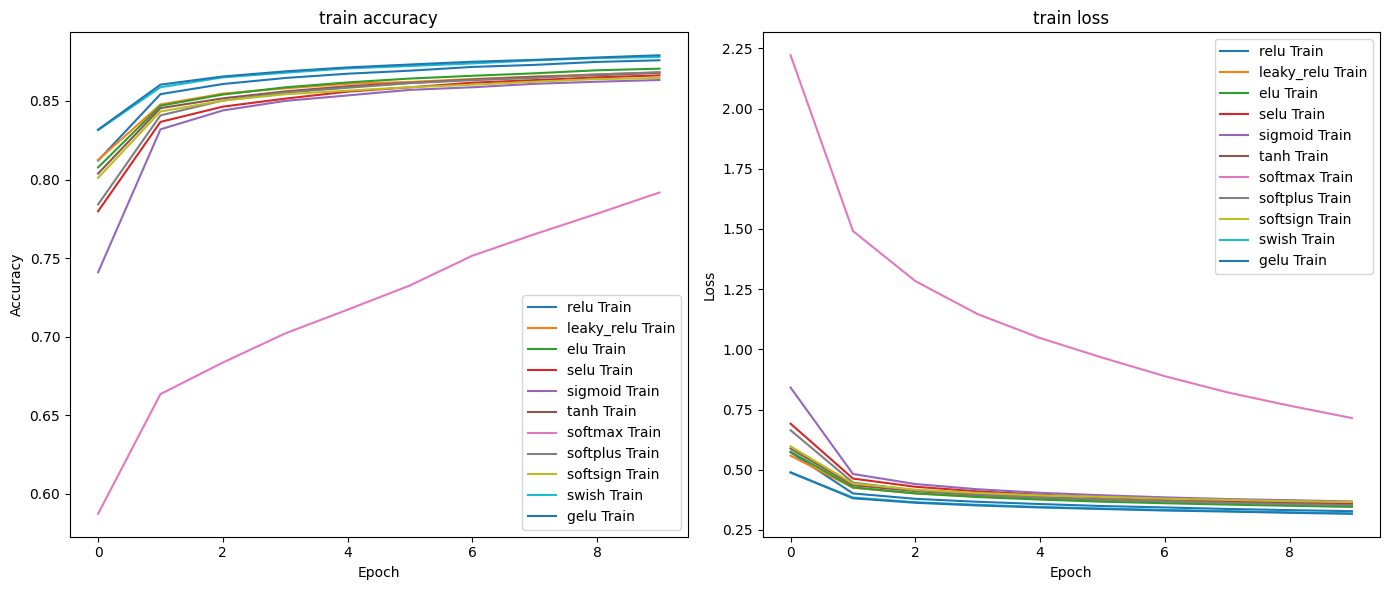

In [42]:
plt.figure(figsize=(14, 6))

for i, h in enumerate(history):
    plt.subplot(1, 2, 1)
    plt.plot(h.history['accuracy'], label=f'{activation_functions[i]} Train')
    plt.title('train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(h.history['loss'], label=f'{activation_functions[i]} Train')
    plt.title('train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig(f"{result_path}/result_activation_{_time}.png")
plt.show()
save_history(history, 'history_activation.pkl')

In [63]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Loss", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Loss"} Comparison')
plt.ylabel("Loss")
plt.xlabel('Activation Function')
plt.ylim([0.8, 1])
plt.tight_layout()
plt.savefig(f'{result_path}/{"Loss".lower().replace(" ", "_")}_comparison_{_time}.png')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Accuracy", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Accuracy"} Comparison')
plt.ylabel("Accuracy")
plt.xlabel('Activation Function')
plt.ylim([0.8, 1])
plt.tight_layout()
plt.savefig(f'{result_path}/{"Accuracy".lower().replace(" ", "_")}_comparison_{_time}.png')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Training Time", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Training Time"} Comparison')
plt.ylabel("Training Time")
plt.xlabel('Activation Function')
plt.tight_layout()
plt.savefig(f'{result_path}/{"Training Time".lower().replace(" ", "_")}_comparison_{_time}.png')
plt.show()

ValueError: Could not interpret value `Activation Function` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

## 2.3. The number of Residual Blocks

In [44]:
history = []
training_time = []

In [45]:
callbacks_final = create_callbacks('final')

In [46]:
our_model_1res = ResModel(num_residual_units=2, activation='gelu')
our_model_2res = ResModel(num_residual_units=2, activation='gelu')
our_model_3res = ResModel(num_residual_units=3, activation='gelu')
our_model_4res = ResModel(num_residual_units=4, activation='gelu')

In [47]:
our_model_1res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_3res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_4res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
EPOCHS = 50
BATCH_SIZE = 500

In [49]:
start_time = time.time()
history.append(our_model_1res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_final]))
end_time = time.time()
training_time.append(end_time-start_time)

start_time = time.time()
history.append(our_model_2res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_final]))
end_time = time.time()
training_time.append(end_time-start_time)


start_time = time.time()
history.append(our_model_3res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_final]))
end_time = time.time()
training_time.append(end_time-start_time)


start_time = time.time()
history.append(our_model_4res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_final]))
end_time = time.time()
training_time.append(end_time-start_time)

Epoch 1/50


2024-05-27 18:09:09.485134: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_22/dropout_112/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5335 - accuracy: 0.8224
Epoch 1: val_loss improved from inf to 0.38116, saving model to ./checkpoints/checkpoints_final/weights.1716800940.hdf5
1257/1257 [==============================] - 32s 23ms/step - loss: 0.5335 - accuracy: 0.8224 - val_loss: 0.3812 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 2/50
   4/1257 [..............................] - ETA: 25s - loss: 0.4111 - accuracy: 0.8450

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1257/1257 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.8577
Epoch 2: val_loss improved from 0.38116 to 0.35000, saving model to ./checkpoints/checkpoints_final/weights.1716800940.hdf5
1257/1257 [==============================] - 28s 22ms/step - loss: 0.3912 - accuracy: 0.8577 - val_loss: 0.3500 - val_accuracy: 0.8692 - lr: 0.0010
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3701 - accuracy: 0.8640
Epoch 3: val_loss improved from 0.35000 to 0.34601, saving model to ./checkpoints/checkpoints_final/weights.1716800940.hdf5
1257/1257 [==============================] - 28s 22ms/step - loss: 0.3702 - accuracy: 0.8640 - val_loss: 0.3460 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 4/50
1254/1257 [============================>.] - ETA: 0s - loss: 0.3575 - accuracy: 0.8671
Epoch 4: val_loss improved from 0.34601 to 0.33572, saving model to ./checkpoints/checkpoints_final/weights.1716800940.hdf5
1257/1257 [==============================] - 28s 

2024-05-27 18:32:33.944740: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_23/dropout_116/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5349 - accuracy: 0.8219
Epoch 1: val_loss did not improve from 0.31569
1257/1257 [==============================] - 32s 23ms/step - loss: 0.5347 - accuracy: 0.8219 - val_loss: 0.3761 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3917 - accuracy: 0.8576
Epoch 2: val_loss did not improve from 0.31569
1257/1257 [==============================] - 27s 22ms/step - loss: 0.3917 - accuracy: 0.8576 - val_loss: 0.3577 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3703 - accuracy: 0.8634
Epoch 3: val_loss did not improve from 0.31569
1257/1257 [==============================] - 27s 22ms/step - loss: 0.3703 - accuracy: 0.8634 - val_loss: 0.3430 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3578 - accuracy: 0.8671
Epoch 4: val_loss did not improve 

2024-05-27 18:55:59.556668: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_24/dropout_120/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.5352 - accuracy: 0.8214
Epoch 1: val_loss did not improve from 0.31543
1257/1257 [==============================] - 39s 27ms/step - loss: 0.5352 - accuracy: 0.8214 - val_loss: 0.3710 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 2/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3878 - accuracy: 0.8582
Epoch 2: val_loss did not improve from 0.31543
1257/1257 [==============================] - 33s 26ms/step - loss: 0.3878 - accuracy: 0.8582 - val_loss: 0.3567 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 3/50
1257/1257 [==============================] - ETA: 0s - loss: 0.3669 - accuracy: 0.8641
Epoch 3: val_loss did not improve from 0.31543
1257/1257 [==============================] - 32s 26ms/step - loss: 0.3669 - accuracy: 0.8641 - val_loss: 0.3459 - val_accuracy: 0.8704 - lr: 0.0010
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3550 - accuracy: 0.8673
Epoch 4: val_loss did not improve 

2024-05-27 19:23:33.044280: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_25/dropout_125/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5457 - accuracy: 0.8183
Epoch 1: val_loss did not improve from 0.31543
1257/1257 [==============================] - 43s 30ms/step - loss: 0.5455 - accuracy: 0.8183 - val_loss: 0.3891 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3926 - accuracy: 0.8570
Epoch 2: val_loss did not improve from 0.31543
1257/1257 [==============================] - 37s 29ms/step - loss: 0.3927 - accuracy: 0.8570 - val_loss: 0.3638 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3719 - accuracy: 0.8630
Epoch 3: val_loss did not improve from 0.31543
1257/1257 [==============================] - 36s 29ms/step - loss: 0.3719 - accuracy: 0.8630 - val_loss: 0.3531 - val_accuracy: 0.8688 - lr: 0.0010
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3595 - accuracy: 0.8667
Epoch 4: val_loss did not improve 

In [50]:
loss_our1res, acc_our1res = our_model_1res.evaluate(x_test, y_test_int)
loss_our2res, acc_our2res = our_model_2res.evaluate(x_test, y_test_int)
loss_our3res, acc_our3res = our_model_3res.evaluate(x_test, y_test_int)
loss_our4res, acc_our4res = our_model_4res.evaluate(x_test, y_test_int)

3636/3636 [==============================] - 12s 3ms/step - loss: 0.3251 - accuracy: 0.8838


In [51]:
results = {
    "Model": ["Our Model(Residual, 1 units)", "Our Model(Residual, 2 units)", "Our Model(Residual, 3 units)", "Our Model(Residual, 4 units)"],
    "Loss": [loss_our1res, loss_our2res, loss_our3res, loss_our4res],
    "Accuracy": [acc_our1res, acc_our2res, acc_our3res, acc_our4res],
    "Training Time": training_time
}

In [52]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_blocks_{_time}.csv', index=False)

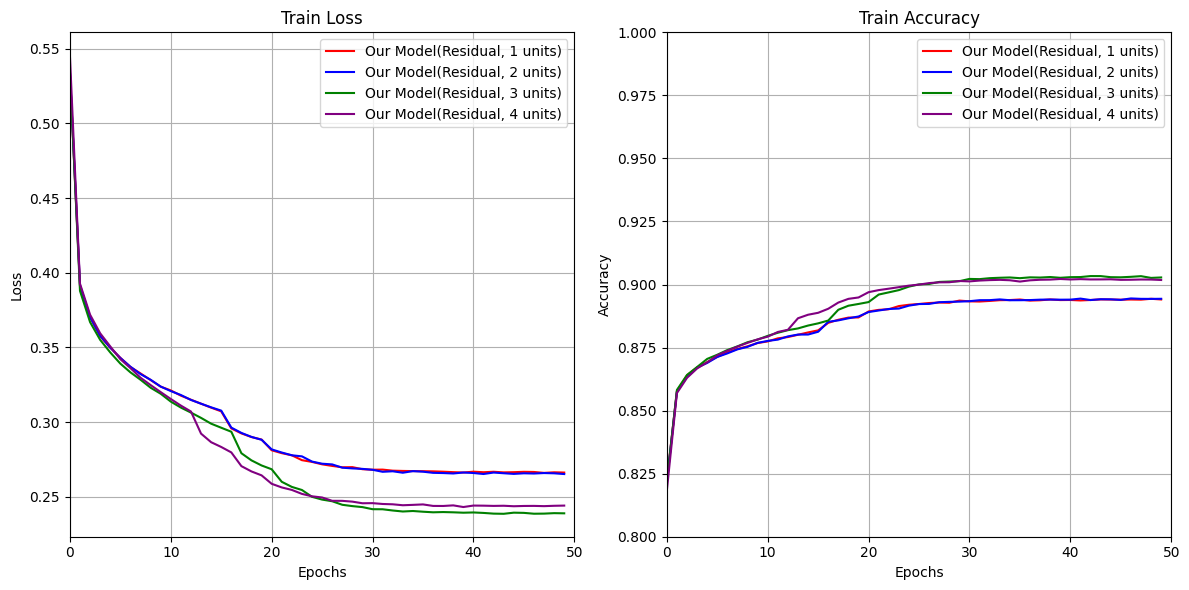

In [53]:
colors = ["red", "blue", "green", "purple", "gold", "orange"]

plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_blocks_{_time}.png")
plt.show()
save_history(history, 'history_blocks.pkl')

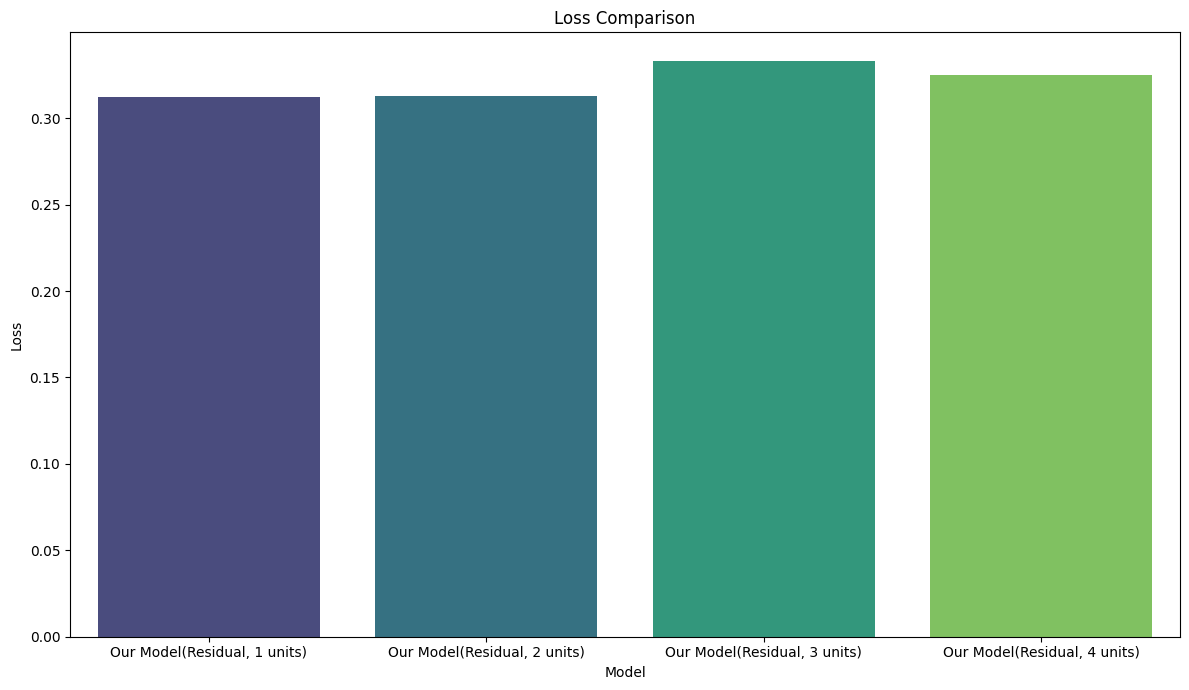

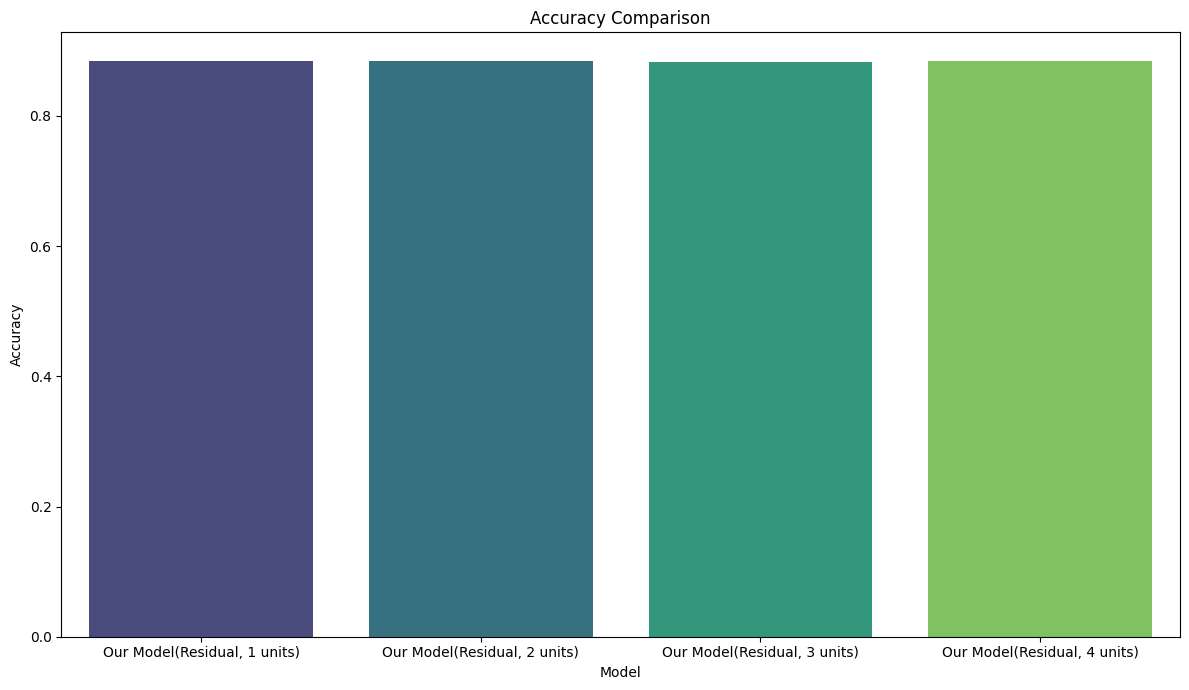

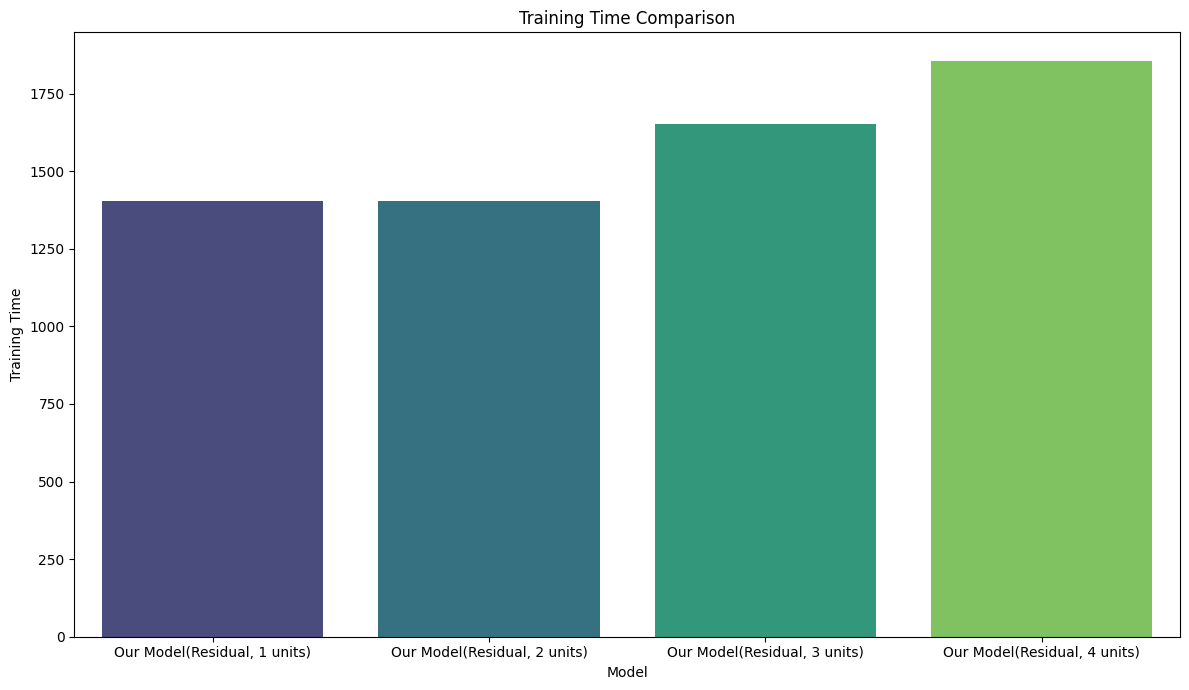

In [54]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Model", y=metric, hue="Model", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_blocks_{_time}.png')
    plt.show()

## 2.4. Learning Rate

## 2.5. Loss function